### Importing Data and Packages

In [7]:
import xarray as xr
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import time

import block_update
import bouguer
import prism_functions
import rfgen
import utilities

import importlib
importlib.reload(block_update)
importlib.reload(bouguer)
importlib.reload(rfgen)
importlib.reload(prism_functions)
importlib.reload(utilities)

from block_update import *
from bouguer import *
from rfgen import *
from prism_functions import *
from utilities import *

In [8]:
bm = xr.open_dataset('bm_fixed.nc')
#Ice shelves mask
bm['ice_shelves'] = ((bm.mask ==3).astype(int))
bach = bm.ice_shelves.where((-1920e3<bm.x) & (bm.x<-1810e3) & (530e3<bm.y) & (bm.y<670e3))
strange= bm.ice_shelves.where((-1900e3<bm.x) & (bm.x<-1700000) & (330e3<bm.y) & (bm.y<480e3))

wilkins1=bm.ice_shelves.where((-2150e3<bm.x) & (bm.x<-1940e3) & (630e3<bm.y) & (bm.y<750e3))
wilkins2=bm.ice_shelves.where((-2070e3<bm.x) & (bm.x<-1980e3) & (570e3<bm.y) & (bm.y<630e3))
wilkins = np.where((wilkins1 == 1) ^ (wilkins2 == 1), 1, 0)

george1=bm.ice_shelves.where((-1810e3<bm.x) & (bm.x<-1700000) & (480e3<bm.y) & (bm.y<850000))
george2=bm.ice_shelves.where((-1940e3<bm.x) & (bm.x<-1810e3) & (670e3<bm.y) & (bm.y<850000))
george3=bm.ice_shelves.where((-2250000<bm.x) & (bm.x<-1940e3) & (750e3<bm.y) & (bm.y<850000))
george6 = np.where((george1 == 1) ^ (george2 == 1) ^ (george3==1), 1, 0)

bm['inv_msk'] = (('y', 'x'), np.where((george6 == 1) ^ (wilkins == 1) ^ (strange == 1) ^ (bach == 1), 1, 0))

bm['inv_msk']=bm.inv_msk.astype(bool)

bm.attrs['res'] = 5000

bm

<xarray.Dataset> Size: 701kB
Dimensions:      (y: 110, x: 120)
Coordinates:
  * x            (x) float32 480B -2.247e+06 -2.242e+06 ... -1.652e+06
  * y            (y) float32 440B 8.478e+05 8.428e+05 ... 3.078e+05 3.028e+05
Data variables:
    mask         (y, x) int64 106kB 0 0 0 0 0 0 0 0 0 0 ... 2 2 2 2 2 2 2 2 2 2
    firn         (y, x) float32 53kB ...
    surface      (y, x) float32 53kB ...
    thickness    (y, x) float32 53kB ...
    bed          (y, x) float32 53kB ...
    errbed       (y, x) float32 53kB ...
    source       (y, x) float64 106kB ...
    dataid       (y, x) float32 53kB ...
    geoid        (y, x) float32 53kB ...
    ice_shelves  (y, x) int64 106kB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    inv_msk      (y, x) bool 13kB False False False False ... False False False
Attributes: (12/18)
    Conventions:                 CF-1.7
    Title:                       BedMachine Antarctica
    Author:                      Mathieu Morlighem
    version:                     03-Jun-2022 (v3.4)
    nx:                          13333.0
    ny:                          13333.0
    ...                          ...
    spacing:                     500
    no_data:                     -9999.0
    license:                     No restrictions on access or use
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    Notes:                       Data processed at the Department of Earth Sy...
    res:                         5000

In [9]:
#Resaving BedMachine data
bm["x"] = bm["x"].astype(float) #makes sure data is saved as floats (not integers)
bm["y"] = bm["y"].astype(float)
bm.to_netcdf(
    'bm_updated.nc', mode='w', format='NETCDF4',
    encoding={                                             #Fills in NaNs with -9999
        'x': {'dtype': 'float32', '_FillValue': -9999.0}, 
        'y': {'dtype': 'float32', '_FillValue': -9999.0}
    }
)

In [10]:
grav=pd.read_csv('gravity_leveled.csv')

grav['inv_msk']=grav.inv_msk.astype(bool)

# make inv_pad, a 10 km padded inversion mask
xx, yy = np.meshgrid(bm.x, bm.y)

inv_pad = vd.distance_mask(
    data_coordinates = (xx[bm.inv_msk==True], yy[bm.inv_msk==True]),
    coordinates = (grav.x, grav.y),
    maxdist = 10e3
)

grav['inv_pad'] = inv_pad

grav

,x,y,faa,height,inv_msk,inv_pad
0,-2207250.0,827750.0,5.127173,1500,False,False
1,-2202250.0,827750.0,8.211898,1500,False,False
2,-2122250.0,827750.0,-5.709144,1500,False,False
3,-2072250.0,827750.0,-13.528602,1500,False,False
4,-2067250.0,827750.0,-13.651285,1500,False,False
...,...,...,...,...,...,...
4553,-1767250.0,322750.0,21.661768,1500,False,False
4554,-1737250.0,322750.0,-9.436692,1500,False,False
4555,-1732250.0,322750.0,-10.493384,1500,False,False
4556,-1717250.0,322750.0,-5.547278,1500,False,False


In [11]:
#Resaving gravity data
grav.to_csv('gravity_updated.csv', index=False)

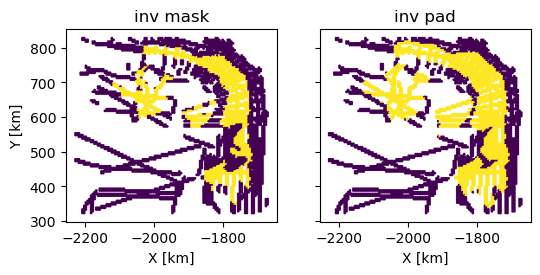

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(6,6), sharey=True)
ax = axs[0]
ax.scatter(grav.x/1000, grav.y/1000, c=grav.inv_msk, s=1)
ax.axis('scaled')
ax.set_title('inv mask')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
ax = axs[1]
ax.scatter(grav.x/1000, grav.y/1000, c=grav.inv_pad, s=1)
ax.axis('scaled')
ax.set_title('inv pad')
ax.set_xlabel('X [km]')
plt.show()

### Make a target terrain effect using SGS and filter

In [13]:
target = nte_correction_sgs(bm, grav, density=2670) # makes an SGS realization of the Bouguer disturbance for the given density

In [14]:
boug_filt = filter_boug(bm, grav, target, cutoff=15e3, pad=0) #filters the Bouguer disturbance with the given cutoff distance
new_target = grav.faa.values - boug_filt

In [15]:
# put gravity into grid for visualization purposes
faa_grid, target_grid, boug_filt_grid = xy_into_grid(
    bm, 
    coords = (grav.x.values, grav.y.values), 
    values = (grav.faa.values, target, boug_filt)
)

In [16]:
boug_sgs = faa_grid - target_grid
new_target_grid = faa_grid - boug_filt_grid

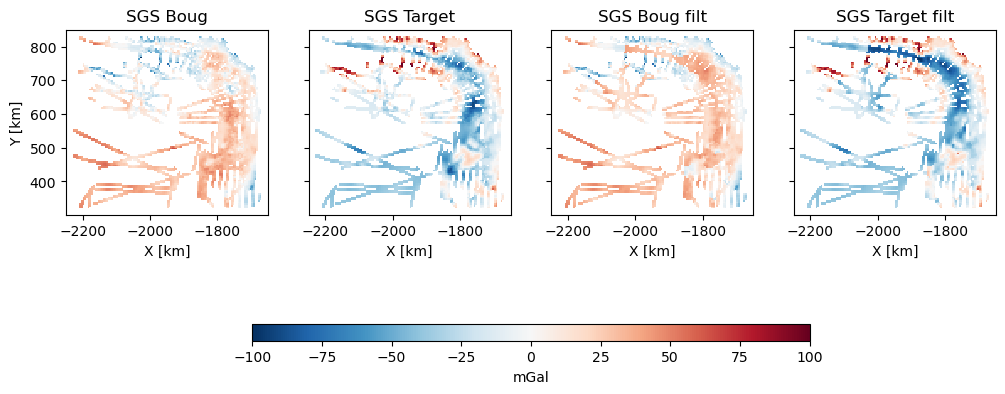

In [17]:
xkm = bm.x/1000
ykm = bm.y/1000

grav_vmin = -100
grav_vmax = 100

fig = plt.figure(figsize=(12,5))

gridspec = GridSpec(2, 4, height_ratios=[1, 0.05])

grids = [boug_sgs, target_grid, boug_filt_grid, new_target_grid]
titles = ['SGS Boug', 'SGS Target', 'SGS Boug filt', 'SGS Target filt']

axs = []
for i, (grid, title) in enumerate(zip(grids, titles)):
    ax = fig.add_subplot(gridspec[0,i])
    axs.append(ax)
    im = ax.pcolormesh(xkm, ykm, grid, vmin=grav_vmin, vmax=grav_vmax, cmap='RdBu_r')
    ax.axis('scaled')
    ax.set_title(title)
    ax.set_xlabel('X [km]')

axs[0].set_ylabel('Y [km]')

for ax in axs[1:]:
    ax.set_yticklabels([])

gs2 = GridSpecFromSubplotSpec(1, 100, gridspec[1,:])
cax = fig.add_subplot(gs2[20:80])
plt.colorbar(im, cax=cax, label='mGal', orientation='horizontal')
plt.show()

I deciced with Micheal to just use the unfiltered values since the data is smooth enough and filtering produces some very unusally data.

### Make a target with for inversion and get the gravity data inside the padded inversion domain

sgs_filt combines the nte_correction_sgs and filter_boug functions, since I am not filtering my data I will just use nte_correction_sgs

In [18]:
%%time

target = nte_correction_sgs(bm, grav, density=2670)
target = target[grav.inv_pad==True]

# trim gravity data
grav_mskd = grav[grav.inv_pad==True]

CPU times: total: 1min 46s
Wall time: 46.8 s


### Genrate a random feild and add it to bed machine

This is done to give the MCMC a better starting point

In [19]:
# make arrays for random field generation
range_max = [50e3, 50e3]
range_min = [30e3, 30e3]
high_step = 300
nug_max = 0.0
eps = 3e-4

rfgen = RFGen(bm, range_max, range_min, high_step, nug_max, eps, 'Gaussian')
field = rfgen.generate_field(condition=True)

x0 = bm.bed.data + field
x0 = np.where(x0>bm.surface-bm.thickness, bm.surface-bm.thickness, x0)

vmax = np.max(np.abs(field))

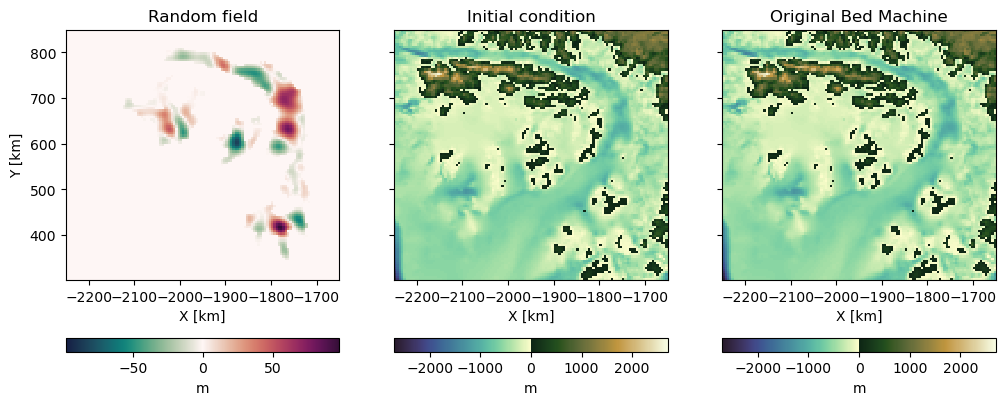

In [20]:
xkm = bm.x/1000
ykm = bm.y/1000

fig, axs = plt.subplots(1, 3, figsize=(12,5), sharey=True)
ax = axs[0]
im = ax.pcolormesh(xkm, ykm, field, vmax=vmax, vmin=-vmax, cmap='cmo.curl')
ax.axis('scaled')
ax.set_title('Random field')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
plt.colorbar(im, ax=ax, label='m', orientation='horizontal')

topo_cm = get_topo_cm()

ax = axs[1]
im = ax.pcolormesh(xkm, ykm, x0, vmax=2700, vmin=-2700, cmap='cmo.topo')
ax.axis('scaled')
ax.set_title('Initial condition')
ax.set_xlabel('X [km]')
plt.colorbar(im, ax=ax, label='m', orientation='horizontal')

ax = axs[2]
im = ax.pcolormesh(xkm, ykm, bm.bed, vmax=2700, vmin=-2700, cmap='cmo.topo')
ax.axis('scaled')
ax.set_title('Original Bed Machine')
ax.set_xlabel('X [km]')
plt.colorbar(im, ax=ax, label='m', orientation='horizontal')

plt.show()

### Creating Prisms to Foreward Model the Terrain Anomaly

In [21]:
density_dict = {
    'ice' : 917,
    'water' : 1027,
    'rock' : 2670
}
pgen = PrismGen(density_dict)

pred_coords = (grav_mskd.x.values, grav_mskd.y.values, grav_mskd.height.values)

### Inversion Parameters

In [22]:
# block size (in pixels), range (in pixels), amplitude, iterations
sequence = [
    [21, 20, 60, 1000],
    [15, 20, 40, 1000],
    [9, 5, 40, 5000],
    [5, 5, 40, 40000]
] #Start with a large block size and shrink
   

# gravity uncertainty
sigma = 2.4 #Constantino, R. R., Tinto, K. J., Bell, R. E., Porter, D. F., & Jordan, T. A. (2020). Seafloor Depth of George VI Sound, Antarctic Peninsula from Inversion of Aerogravity Data. Geophysical Research Letters, 47(21). https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2020GL088654 

# RMSE stopping condition
stop = 4.7

# get random number generator
rng = np.random.default_rng(seed=0)

### Chain Sequencing

In [23]:
# run chain sequence and time it
tic = time.time()
result = chain_sequence(sequence, bm, x0, pred_coords, target, sigma, pgen, rng, stop=stop)
toc = time.time()
print(f'total time: {toc-tic:.1f}')

  0%|          | 0/1000 [00:00<?, ?it/s]

chain 0 efficiency: -0.082 RMSE/sec


  0%|          | 0/1000 [00:00<?, ?it/s]

chain 1 efficiency: -0.014 RMSE/sec


  0%|          | 0/5000 [00:00<?, ?it/s]

chain 2 efficiency: -0.010 RMSE/sec


  0%|          | 0/40000 [00:00<?, ?it/s]

chain 3 efficiency: -0.002 RMSE/sec
0 finished
total time: 306.0


This results in a reasonable runtime (between 3 and 5 minutes)

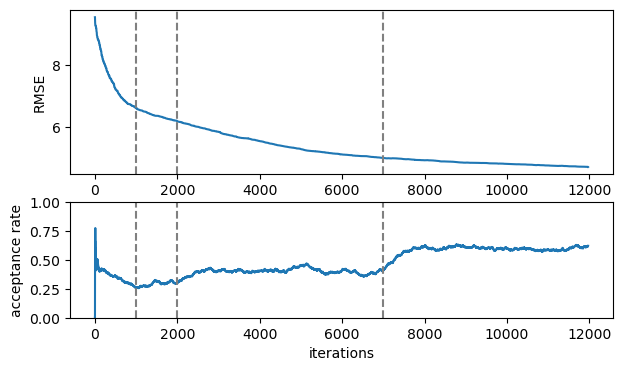

In [24]:
from diagnostics import run_acceptance_rate

rmse = np.sqrt(result['loss_cache']/target.size)

fig, axs = plt.subplots(2, 1, figsize=(7,4), gridspec_kw=dict(height_ratios=[1,0.7]))
ax = axs[0]
ax.plot(rmse)
ax.axvline(x=1000, color='grey', linestyle='--', linewidth=1.5, label='Begin 2nd Block parameters')
ax.axvline(x=2000, color='grey', linestyle='--', linewidth=1.5, label='Begin 3rd Block parameters')
ax.axvline(x=7000, color='grey', linestyle='--', linewidth=1.5, label='Begin 4th Block parameters')
ax.set_ylabel('RMSE')

# running acceptance rate with a 500 iteration window
run_acc = run_acceptance_rate(result['step_cache'], 500, 0)

ax = axs[1]
ax.plot(run_acc)
ax.set_xlabel('iterations')
ax.set_ylabel('acceptance rate')
ax.axvline(x=1000, color='grey', linestyle='--', linewidth=1.5, label='Begin 2nd Block parameters')
ax.axvline(x=2000, color='grey', linestyle='--', linewidth=1.5, label='Begin 3rd Block parameters')
ax.axvline(x=7000, color='grey', linestyle='--', linewidth=1.5, label='Begin 4th Block parameters')
ax.set_ylim(0, 1)
plt.show()

### Plot the Final Inversion

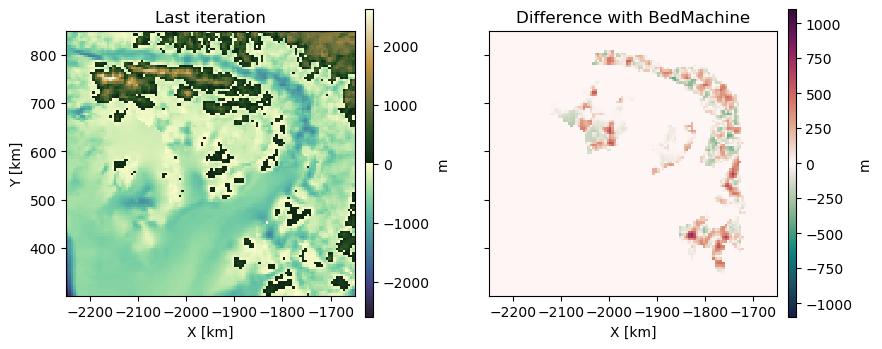

In [25]:
bed = result['bed_cache']
vmin_topo = np.min(bed); vmax_topo = np.max(bed)

fig, axs = plt.subplots(1, 2, figsize=(10,4), sharey=True)

# plot last bed iteration
ax = axs[0]
im = ax.pcolormesh(xkm, ykm, bed, vmin=vmin_topo, vmax=vmax_topo, cmap='cmo.topo')
ax.axis('scaled')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
ax.set_title('Last iteration')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40, label='m')

# plot difference from BedMachine
ax = axs[1]
im = ax.pcolormesh(xkm, ykm, bm.bed-bed, vmin=-1100, vmax=1100, cmap='cmo.curl')
ax.axis('scaled')
ax.set_xlabel('X [km]')
ax.set_title('Difference with BedMachine')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40, label='m')

plt.savefig('Ensemble_Results1.png', dpi=300, bbox_inches='tight')
plt.show()

### Calculating Residual Gravity
(The difference between our original gravity in the inversion domain and the gravity data corresponding with our final region.)

In [20]:
target_grid, grav_result_grid = xy_into_grid(bm, (pred_coords[0], pred_coords[1]), 
                                             (target, result['grav_cache']))

residual_grid = target_grid - grav_result_grid

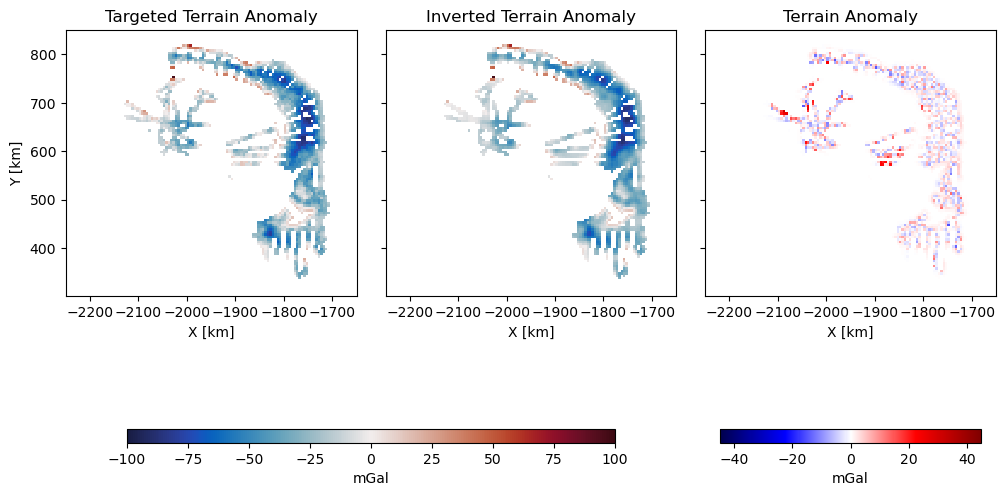

In [21]:
#fig, axs = plt.subplots(1, 3, figsize=(15,5), sharey=True)

fig = plt.figure(figsize=(12,6.5))
gridspec = GridSpec(2, 3, height_ratios=[1, 0.03], wspace=0.1)

norm=plt.Normalize(vmin=-100, vmax=100)

ax1 = fig.add_subplot(gridspec[0,0])
ax2 = fig.add_subplot(gridspec[0,1])
ax3 = fig.add_subplot(gridspec[0,2])

ax = ax1
im = ax.pcolormesh(xkm, ykm, target_grid,norm=norm, cmap='cmo.balance')
ax.axis('scaled')
ax.set_title('Targeted Terrain Anomaly')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')

ax = ax2
im = ax.pcolormesh(xkm, ykm, grav_result_grid,norm=norm, cmap='cmo.balance')
ax.axis('scaled')
ax.set_title('Inverted Terrain Anomaly')
ax.set_xlabel('X [km]')
ax.set_yticklabels([])

gs2 = GridSpecFromSubplotSpec(1, 100, gridspec[1,:2])
cax = fig.add_subplot(gs2[10:90])
plt.colorbar(im, cax=cax, label='mGal', orientation='horizontal')

ax = ax3
im = ax.pcolormesh(xkm, ykm, residual_grid, vmin=-45, vmax=45, cmap='seismic')
ax.axis('scaled')
ax.set_title('Terrain Anomaly')
ax.set_xlabel('X [km]')
ax.set_yticklabels([])

gs3 = GridSpecFromSubplotSpec(1, 100, gridspec[1,2])
cax = fig.add_subplot(gs3[5:95])
plt.colorbar(im, cax=cax, label='mGal', orientation='horizontal')
plt.show()